## Step 1: Import Packages


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score


## Step 2: Load and Prepare Data


In [ ]:
# Load the cleaned data
sales_pipeline = pd.read_csv('../data_directory/sales_pipeline_clean.csv')
accounts = pd.read_csv('../data_directory/accounts_clean.csv')

# Merge the data
df = sales_pipeline.merge(accounts, on='account', how='left')

# Convert dates
df['engage_date'] = pd.to_datetime(df['engage_date'], errors='coerce')
df['close_date'] = pd.to_datetime(df['close_date'], errors='coerce')

# Create simple features
current_date = pd.to_datetime('2017-12-31')
df['lead_age_days'] = (df['close_date'].fillna(current_date) - df['engage_date']).dt.days
df['lead_age_days'] = df['lead_age_days'].clip(lower=0)

# Normalize features to [0,1] range like in the class example
df['revenue_norm'] = (df['revenue'] - df['revenue'].min()) / (df['revenue'].max() - df['revenue'].min())
df['employees_norm'] = (df['employees'] - df['employees'].min()) / (df['employees'].max() - df['employees'].min())
df['age_norm'] = (df['lead_age_days'] - df['lead_age_days'].min()) / (df['lead_age_days'].max() - df['lead_age_days'].min())

print(f"Dataset shape: {df.shape}")


Data loaded and features created!
Dataset shape: (8800, 18)


## Step 3: Create Labeled Examples


In [31]:
# Filter to only Won and Lost deals (our binary classification problem)
df_model = df[df['deal_stage'].isin(['Won', 'Lost'])].copy()

# Define the label (1 for Won, 0 for Lost)
y = (df_model['deal_stage'] == 'Won').astype(int)

# Define features (simple numerical features only)
X = df_model[['revenue_norm', 'employees_norm', 'age_norm']].fillna(0)

print(f"Label distribution: {y.value_counts()}")
print(f"Features shape: {X.shape}")
print(f"Conversion rate: {y.mean():.2%}")


Label distribution: deal_stage
1    4238
0    2473
Name: count, dtype: int64
Features shape: (6711, 3)
Conversion rate: 63.15%


## Step 4: Create Training and Test Data Sets


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training conversion rate: {y_train.mean():.2%}")
print(f"Test conversion rate: {y_test.mean():.2%}")


Training set size: 4496
Test set size: 2215
Training conversion rate: 63.63%
Test conversion rate: 62.17%


## Step 5: Train Two Gradient Boosted Decision Tree Classifiers


In [ ]:
from time import process_time
print('Begin GBDT Implementation')

# 1. Create the GradientBoostingClassifier model object with a max depth of 2
gbdt_2_model = GradientBoostingClassifier(n_estimators=50, max_depth=2, random_state=1234)

# 2. Fit the model to the training data 
gbdt_2_model.fit(X_train, y_train)

# 3. Make predictions on the test data using predict_proba()
gbdt_2_preds = gbdt_2_model.predict_proba(X_test)
gbdt_2_predictions = list(gbdt_2_preds[:, -1])

# 4. Create the GradientBoostingClassifier model object with a max depth of 10
gbdt_10_model = GradientBoostingClassifier(n_estimators=50, max_depth=10, random_state=1234)

# 5. Fit the model to the training data
gbdt_10_model.fit(X_train, y_train)

# 6. Make predictions on the test data using predict_proba()
gbdt_10_preds = gbdt_10_model.predict_proba(X_test)
gbdt_10_predictions = list(gbdt_10_preds[:, -1])

print('End')


Begin GBDT Implementation (this will take a few minutes)...
End


## Step 6: Evaluate Performance Using ROC and AUC


In [ ]:
print('Computing ROC Curve')

# Use roc_curve to record fpr and tpr for gbdt_2_model
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, gbdt_2_predictions)

# Use roc_curve to record fpr and tpr for gbdt_10_model
fpr_10, tpr_10, thresholds_10 = roc_curve(y_test, gbdt_10_predictions)

print('End')


Computing ROC Curve...
End


Plotting ROC Curve...


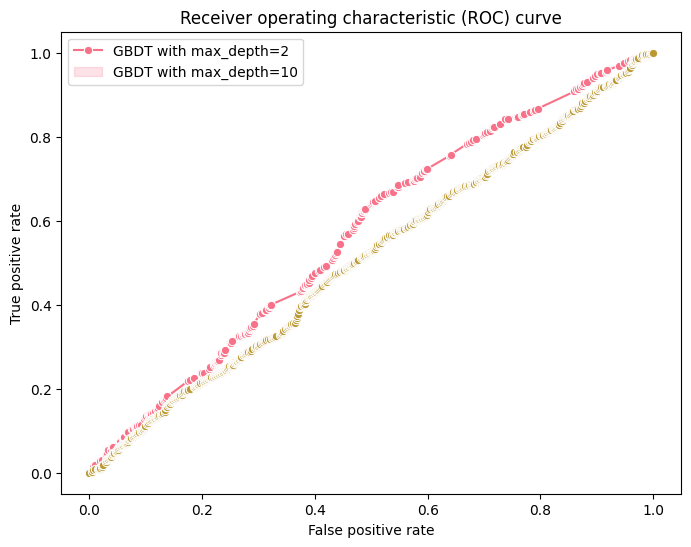

Plotting time: 5.30 seconds


In [ ]:
import time

t0 = time.time()

print('Plotting ROC Curve:')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

sns.lineplot(x=fpr_2, y=tpr_2, marker='o')
sns.lineplot(x=fpr_10, y=tpr_10, marker='o')

plt.title("Receiver operating characteristic (ROC) curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(['GBDT with max_depth=2', 'GBDT with max_depth=10'])
plt.show()

t1 = time.time()
print(f"Plotting time: {t1-t0:.2f} seconds")


In [36]:
# Compute AUC scores
auc_2 = auc(fpr_2, tpr_2)
auc_10 = auc(fpr_10, tpr_10)

print(f"AUC for GBDT with max_depth=2: {auc_2:.3f}")
print(f"AUC for GBDT with max_depth=10: {auc_10:.3f}")

# Also compute accuracy for comparison
acc_2 = accuracy_score(y_test, (np.array(gbdt_2_predictions) > 0.5).astype(int))
acc_10 = accuracy_score(y_test, (np.array(gbdt_10_predictions) > 0.5).astype(int))

print(f"Accuracy for GBDT with max_depth=2: {acc_2:.3f}")
print(f"Accuracy for GBDT with max_depth=10: {acc_10:.3f}")

# Check against our 42% baseline
baseline = 0.42
print(f"\nBaseline accuracy: {baseline:.1%}")
print(f"GBDT max_depth=2 improvement: {((acc_2 - baseline) / baseline * 100):+.1f}%")
print(f"GBDT max_depth=10 improvement: {((acc_10 - baseline) / baseline * 100):+.1f}%")


AUC for GBDT with max_depth=2: 0.570
AUC for GBDT with max_depth=10: 0.512
Accuracy for GBDT with max_depth=2: 0.627
Accuracy for GBDT with max_depth=10: 0.560

Baseline accuracy: 42.0%
GBDT max_depth=2 improvement: +49.3%
GBDT max_depth=10 improvement: +33.3%
